# Analyzing DNA binding mutants 

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import pandas as pd
import glob
import sys
sys.path.insert(0, '../../')
import mwc.viz
import mwc.thermo
import mwc.stats
import mwc.bayes
colors = mwc.viz.pub_style()
%matplotlib inline

In [247]:
# Define the files
files = glob.glob('../../data/csv/2018*.csv')
dfs = [pd.read_csv(i, comment='#') for i in files]
df = pd.concat(dfs, ignore_index=True)

# Remove the auto and delta strains. 
idx_id = {'wt':0, 'Q21M':1, 'Q21A':2, 'Y20I':3}
df = df[df['date'] != 20180123]
df = df[df['fold_change'] >= 0]
df = df[(df['mutant'] != 'auto') & (df['mutant'] != 'delta')]
df['idx'] = [idx_id[df.iloc[i]['mutant']] for i in range(len(df))]
grouped = df.groupby(['mutant', 'strain', 'IPTGuM'])


In [266]:
df

,IPTGuM,date,fold_change,mean_FITC_H,mutant,operator,repressors,strain,username,idx
2,0.0,20180202,0.022544,5061.323447,Q21M,O2,60.0,R60,sbarnes,1
3,0.0,20180202,0.008672,4814.352752,Q21M,O2,124.0,R124,sbarnes,1
4,0.0,20180202,0.008332,4808.303333,wt,O2,260.0,R260,sbarnes,0
5,0.0,20180202,0.012264,4878.298203,Q21M,O2,260.0,R260,sbarnes,1
8,0.1,20180202,0.010162,4901.658869,Q21M,O2,60.0,R60,sbarnes,1
9,0.1,20180202,0.003349,4762.894867,Q21M,O2,260.0,R260,sbarnes,1
10,0.1,20180202,0.010695,4912.508152,Q21M,O2,124.0,R124,sbarnes,1
12,0.1,20180202,0.010294,4904.342660,wt,O2,260.0,R260,sbarnes,0
14,5.0,20180202,0.025994,5127.001413,wt,O2,260.0,R260,sbarnes,0
16,5.0,20180202,0.012357,4824.009322,Q21M,O2,260.0,R260,sbarnes,1


/Users/gchure/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


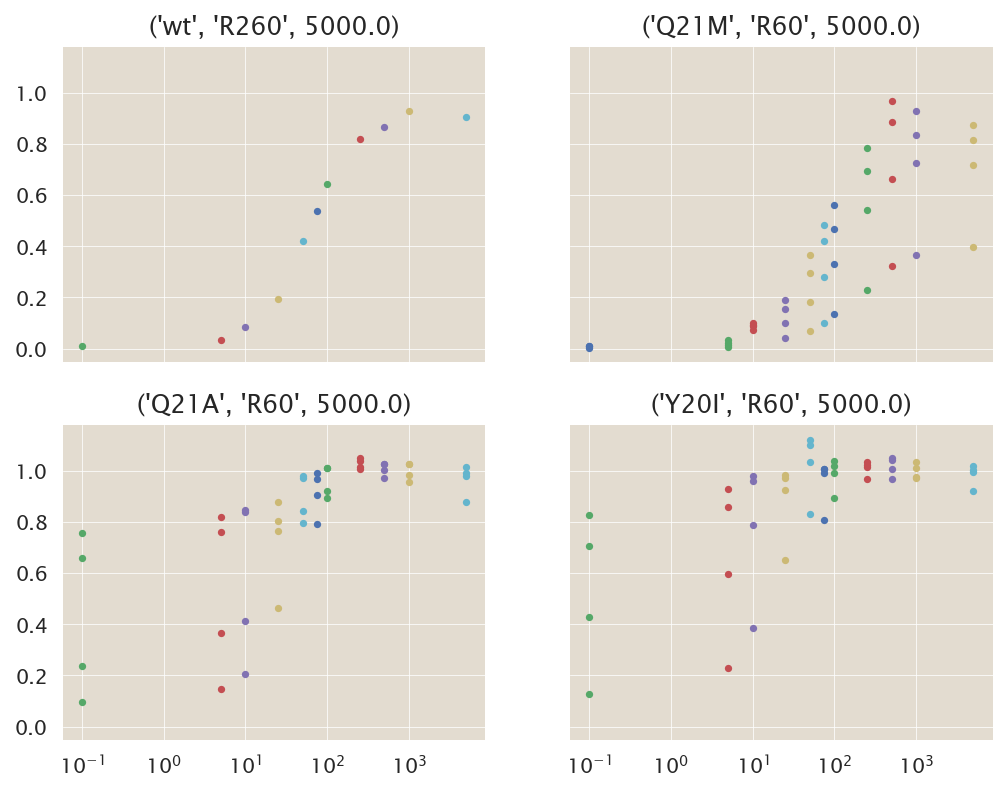

In [248]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.ravel()
axes = {'wt':ax[0], 'Q21M':ax[1], 'Q21A':ax[2], 'Y20I':ax[3]}
for a in ax:
    a.set_xscale('log')
for g, d in grouped:
    axes[g[0]].plot(d['IPTGuM'].mean(), d['fold_change'].mean(), '.')
    axes[g[0]].set_title(g)

It will be better to fit the log fold change I think. Let's just try things with the WT to make sure they are working as expected. 

In [249]:
# Look only at the leakiness values. 
leakiness = df[(df['IPTGuM'] == 0)]

In [ ]:
# Set up the model.
with pm.Model() as model:
    # Set the priors for the binding energy
    ep = pm.Normal('ep', mu=0, sd=10, shape=4)
    sigma = pm.HalfNormal('sigma', sd=10, shape=4)
    
    # Compute the log fold change.
    idx = leakiness['idx']
    arch = mwc.thermo.SimpleRepression(R=leakiness['repressors'].values[idx], ep_r=ep[idx],
                                              ka=153, ki=0.53, ep_ai=4.5, effector_conc=0)
    mu = arch.fold_change()
    
    like = pm.Normal('like', mu=mu, sd=sigma[idx], observed=leakiness['fold_change'].values)
    trace = pm.sample(tune=10000, draws=10000, njobs=4, init='advi')
    trace_df = mwc.stats.trace_to_dataframe(trace, model)
    stats = mwc.stats.compute_statistics(trace_df)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 77.22:  23%|██▎       | 45744/200000 [00:27<01:31, 1690.35it/s] 
Convergence archived at 45900
Interrupted at 45,899 [22%]: Average Loss = 89.895
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, ep]
 45%|████▌     | 9098/20000 [40:08<48:05,  3.78it/s]

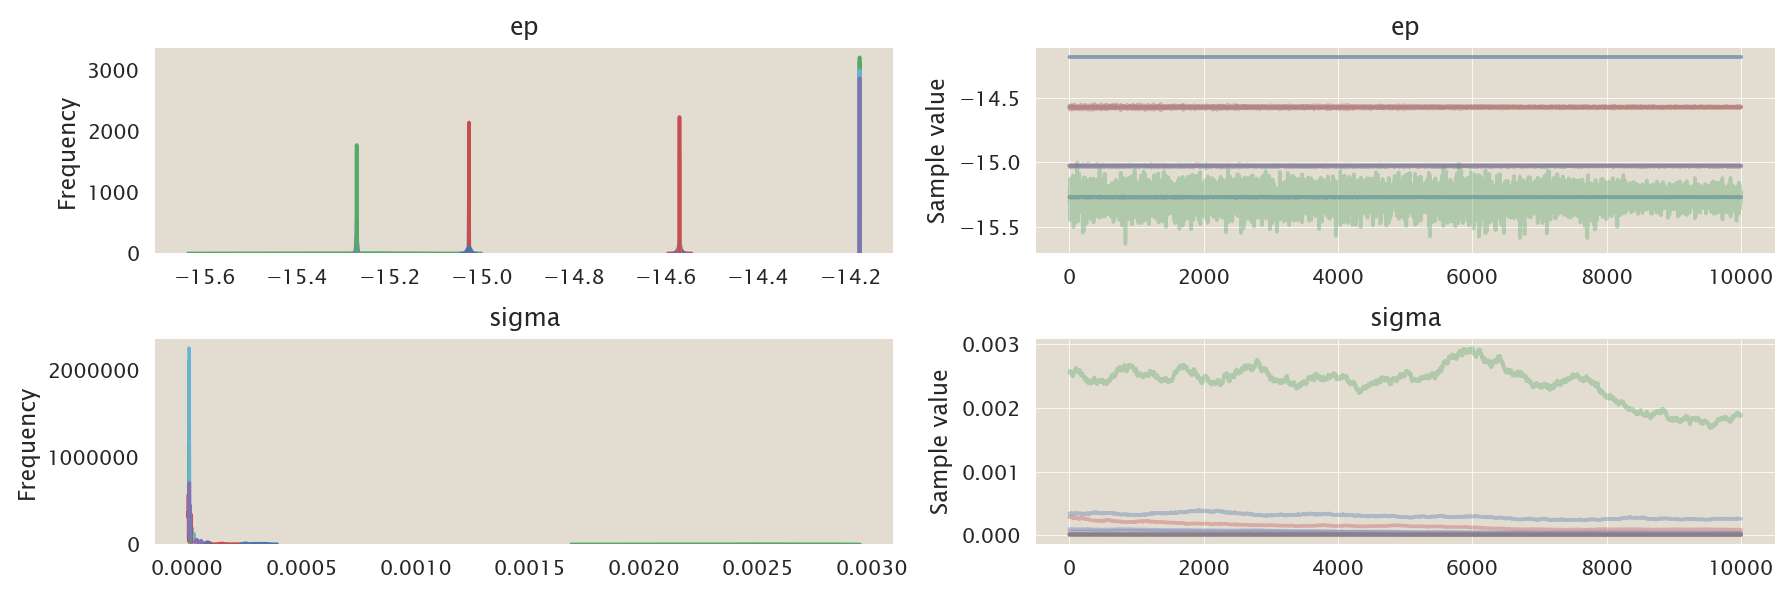

In [269]:
_ = pm.traceplot(trace)

In [260]:
# Extract the modes.
modes = {}
for k, v in idx_id.items():
    modes[k] = stats[stats['parameter']=='ep__{}'.format(v)]['mode'].values[0]

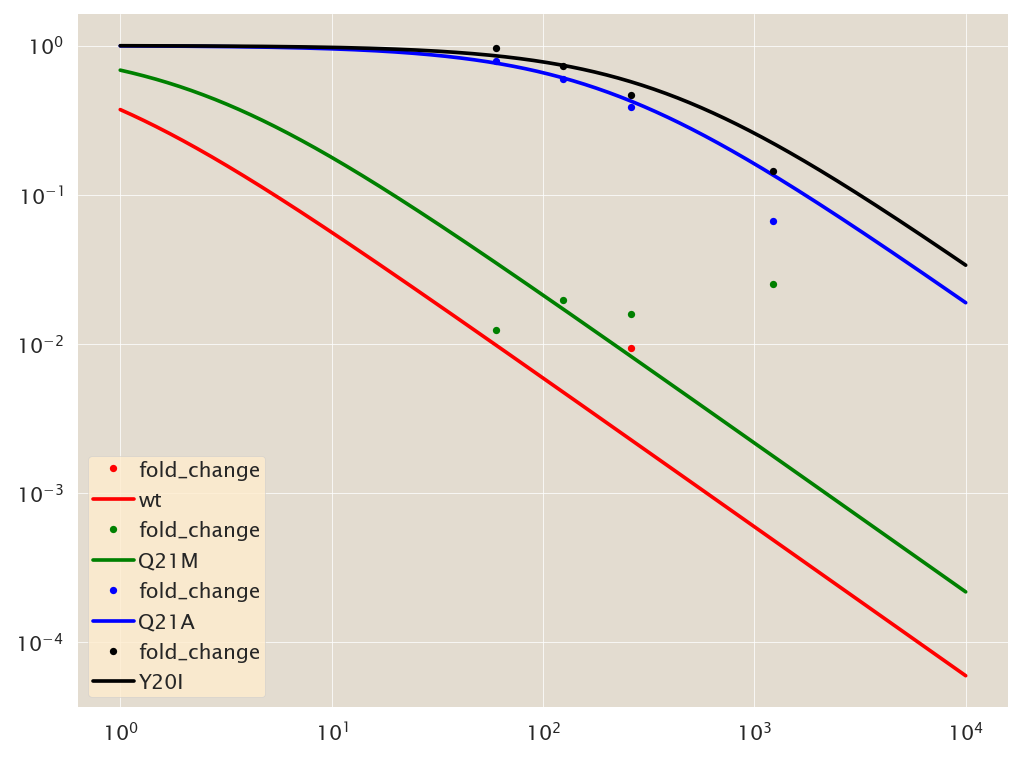

In [265]:
# Plot them. 
colors=['r', 'g', 'b', 'k']
for i, k in enumerate(modes.keys()):
    # Grab the data. 
    d = leakiness[leakiness['mutant'] == k].groupby('repressors')['fold_change'].mean()
    plt.loglog(d,'.', color=colors[i])
    theo = mwc.thermo.SimpleRepression(R=rep_range, ep_r=modes[k], ka=153, 
                                       ki=0.53, ep_ai=4.5, effector_conc=0) 
    plt.loglog(rep_range, theo.fold_change(), color=colors[i], label=k)

plt.legend()

In [262]:
d

In [263]:
stats

,parameter,mode,hpd_min,hpd_max
0,ep__0,-15.877319,-16.855482,-15.436655
1,ep__1,-14.581792,-14.998527,-14.322456
2,ep__2,-10.096092,-11.050765,-9.129170
3,ep__3,-9.501168,-10.106799,-8.770372
4,sigma__0,0.007153,0.004426,0.011969
5,sigma__1,0.008221,0.005883,0.013808
6,sigma__2,0.304505,0.200817,0.519059
7,sigma__3,0.346458,0.264259,0.487506
